In [64]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Preprocessing & Feature Engineering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Modeling
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Pandas display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.3f}'.format) # Format floats
# Seaborn style
sns.set_theme(style="whitegrid")
# Random seed for reproducibility
seed = 42
print("Libraries imported and basic settings configured.")

Libraries imported and basic settings configured.


In [65]:
# Cell 2: Configuration
# --- Paths and Key Column Names ---
ACLED_RAW_PATH = 'data/raw/afgh_may25.csv' 
OUTPUT_DIR_MODELS = 'data/intermediate/logfat_prediction_models_final/' 
os.makedirs(OUTPUT_DIR_MODELS, exist_ok=True)

# Define key column names from ACLED data (Verify these match your CSV)
COL_EVENT_ID = 'event_id_cnty'
COL_EVENT_DATE = 'event_date'
COL_YEAR = 'year' 
COL_MONTH = 'month'
COL_DAYOFWEEK = 'dayofweek' 
COL_LATITUDE = 'latitude'
COL_LONGITUDE = 'longitude'
COL_COUNTRY = 'country'
COL_ADMIN1 = 'admin1' 
COL_LOCATION = 'location' 
COL_EVENT_TYPE = 'event_type'
COL_SUB_EVENT_TYPE = 'sub_event_type'
COL_ACTOR1 = 'actor1'
COL_FATALITIES = 'fatalities'
COL_GEO_PRECISION = 'geo_precision'
COL_TIME_PRECISION = 'time_precision'
# TALIBAN_TEXT_COLUMN = 'body' # Not directly used in ML features for this version

# --- Target and Regime Shift ---
TARGET_COL = 'log_fatalities'
TAKEOVER_DATE_STR = "2021-08-15"; TAKEOVER_DATE = pd.to_datetime(TAKEOVER_DATE_STR)
PRE_TAKEOVER_END_DATE = TAKEOVER_DATE - pd.Timedelta(days=1)
POST_TAKEOVER_START_DATE = TAKEOVER_DATE + pd.Timedelta(days=16) # Start Sep 2021

# --- Feature Engineering Parameters ---
HISTORY_LAGS_DAYS = [7, 30, 90] 
MIN_ACTOR_FREQ = 10 
GRID_CELL_SIZE_DEG = 0.25 
TREND_WINDOWS_TO_CALCULATE = [30, 90] # List of trend windows (e.g., 30-day trend, 90-day trend)

# --- K-Means for Event Archetypes ---
CHOSEN_K_ARCHETYPES = 5 

# --- ML Splitting Parameters ---
PERIOD_TEST_FRAC = 0.20 
PERIOD_VAL_FRAC_FROM_TRAIN = 0.20 # Validation set as fraction of (Train+Validation)

# --- XGBoost Hyperparameter Grid ---
XGB_PARAM_GRID = {
    'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1],
    'subsample': [0.8], 'colsample_bytree': [0.8]
}
# Minimal grid for very quick test:
# XGB_PARAM_GRID = {'n_estimators': [50], 'max_depth': [3], 'learning_rate': [0.1]}

print("Configuration loaded.")

Configuration loaded.


In [66]:
# Cell 3: Load and Initial Clean ACLED Data
df_acled_full = pd.DataFrame() 
try:
    df_acled_full = pd.read_csv(ACLED_RAW_PATH, low_memory=False)
    if COL_COUNTRY in df_acled_full.columns:
        df = df_acled_full[df_acled_full[COL_COUNTRY] == "Afghanistan"].copy()
    else:
        df = df_acled_full.copy() # Assume data is already for Afghanistan
    print(f"Loaded ACLED data. Afghanistan subset shape: {df.shape}")
except FileNotFoundError:
    print(f"ERROR: ACLED data file '{ACLED_RAW_PATH}' not found. Halting.")
    exit() # Critical error, stop execution

if df.empty: print("DataFrame is empty after country filter or due to load error. Halting."); exit()

# Core Cleaning and Basic Feature Creation
df[COL_EVENT_DATE] = pd.to_datetime(df[COL_EVENT_DATE], errors='coerce')
df.dropna(subset=[COL_EVENT_DATE], inplace=True) # Essential for any time-based analysis

numeric_cols = [COL_LATITUDE, COL_LONGITUDE, COL_FATALITIES, COL_GEO_PRECISION, COL_TIME_PRECISION]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if col == COL_FATALITIES: 
            df[col] = df[col].fillna(0).astype(int)
    elif col == COL_FATALITIES: # Ensure fatalities column exists if missing from original
        df[COL_FATALITIES] = 0
        print(f"Warning: '{COL_FATALITIES}' column created with zeros as it was missing.")

# Define target variable
df[TARGET_COL] = np.log1p(df[COL_FATALITIES])

# Basic time features
df[COL_YEAR] = df[COL_EVENT_DATE].dt.year
df[COL_MONTH] = df[COL_EVENT_DATE].dt.month
df[COL_DAYOFWEEK] = df[COL_EVENT_DATE].dt.dayofweek
df['is_post_takeover'] = (df[COL_EVENT_DATE] >= TAKEOVER_DATE).astype(int)

# Drop rows if essential columns for modeling are missing after conversions
essential_cols_for_modeling = [COL_EVENT_DATE, COL_LATITUDE, COL_LONGITUDE, COL_ADMIN1, TARGET_COL]
cols_to_check_for_na = [col for col in essential_cols_for_modeling if col in df.columns]
df.dropna(subset=cols_to_check_for_na, inplace=True)

df.sort_values(COL_EVENT_DATE, inplace=True)
df.reset_index(drop=True, inplace=True)
print(f"Data initially cleaned and basic features created. Shape: {df.shape}")
if df.empty: print("DataFrame empty after initial cleaning. Halting."); exit()

Loaded ACLED data. Afghanistan subset shape: (7940, 32)
Data initially cleaned and basic features created. Shape: (7940, 36)


In [67]:
# Cell 4: Feature Engineering Functions
def add_grid_cell_id(df_input, lat_col, lon_col, cell_size_deg):
    """Assigns events to a spatial grid cell ID."""
    print(f"  Adding grid_cell_id (cell size: {cell_size_deg} deg)...")
    df_out = df_input.copy()
    if not all(c in df_out.columns and pd.api.types.is_numeric_dtype(df_out[c]) for c in [lat_col, lon_col]):
        print(f"    ERROR: Lat/Lon columns missing or not numeric. Cannot create grid cells."); df_out['grid_cell_id'] = None; return df_out
    min_lat, max_lat = df_out[lat_col].min(), df_out[lat_col].max()
    min_lon, max_lon = df_out[lon_col].min(), df_out[lon_col].max()
    if any(pd.isna(x) for x in [min_lat, max_lat, min_lon, max_lon]):
        print("    ERROR: Min/Max lat/lon is NaN. Cannot create grid bins."); df_out['grid_cell_id'] = None; return df_out
    lat_bins = np.arange(min_lat, max_lat + cell_size_deg, cell_size_deg)
    lon_bins = np.arange(min_lon, max_lon + cell_size_deg, cell_size_deg)
    df_out['lat_bin_idx'] = pd.cut(df_out[lat_col], bins=lat_bins, labels=False, include_lowest=True, right=False)
    df_out['lon_bin_idx'] = pd.cut(df_out[lon_col], bins=lon_bins, labels=False, include_lowest=True, right=False)
    df_out['grid_cell_id'] = df_out.apply(lambda r: f"cell_{int(r['lat_bin_idx'])}_{int(r['lon_bin_idx'])}" if pd.notna(r['lat_bin_idx']) and pd.notna(r['lon_bin_idx']) else None, axis=1)
    if 'grid_cell_id' in df_out.columns and df_out['grid_cell_id'].notna().any(): df_out.dropna(subset=['grid_cell_id'], inplace=True)
    df_out.drop(columns=['lat_bin_idx', 'lon_bin_idx'], inplace=True, errors='ignore')
    if 'grid_cell_id' in df_out.columns: print(f"    Assigned events to {df_out['grid_cell_id'].nunique()} grid cells.")
    return df_out

def engineer_history_and_trend(df_period, id_col, date_col, target_col_for_sum, 
                               spatial_unit_col, lags_days_list, trend_windows_days_list):
    """Engineers lagged sum/count and trend features for a given spatial unit."""
    if df_period.empty: print(f"Input DataFrame for '{spatial_unit_col}' is empty. Skipping."); return df_period
    required_cols_for_fn = [id_col, date_col, target_col_for_sum, spatial_unit_col]
    if not all(c in df_period.columns for c in required_cols_for_fn):
        print(f"Missing one or more required columns ({required_cols_for_fn}) for history/trend on '{spatial_unit_col}'. Skipping."); return df_period
        
    print(f"  Engineering history & trend for '{spatial_unit_col}'...")
    df_out = df_period.copy(); df_out.sort_values([spatial_unit_col, date_col], inplace=True)
    
    # Aggregate activity to daily level per spatial unit
    daily_agg = df_out.groupby([spatial_unit_col, pd.Grouper(key=date_col, freq='D')]).agg(
        _daily_event_count=(id_col, 'size'), 
        _daily_target_sum=(target_col_for_sum, 'sum') # Use temporary names
    ).reset_index() # Reset to allow direct rolling on series after another groupby

    # Calculate lagged sums
    for lag_d in lags_days_list:
        ev_col=f'events_in_{spatial_unit_col}_prior_{lag_d}d'; tg_col=f'sum_target_in_{spatial_unit_col}_prior_{lag_d}d'
        daily_agg[ev_col] = daily_agg.groupby(spatial_unit_col)['_daily_event_count'].transform(lambda x: x.shift(1,fill_value=0).rolling(window=lag_d,min_periods=0).sum()).fillna(0).astype(int)
        daily_agg[tg_col] = daily_agg.groupby(spatial_unit_col)['_daily_target_sum'].transform(lambda x: x.shift(1,fill_value=0).rolling(window=lag_d,min_periods=0).sum()).fillna(0)
    
    # Calculate trend features
    if isinstance(trend_windows_days_list, list):
        for trend_w in trend_windows_days_list:
            et_col=f'events_trend_{spatial_unit_col}_{trend_w}d'; cs_col=f'_tsl_{trend_w}d'; ps_col=f'_tsp_{trend_w}d'
            daily_agg[cs_col] = daily_agg.groupby(spatial_unit_col)['_daily_event_count'].transform(lambda x: x.shift(1,fill_value=0).rolling(window=trend_w,min_periods=0).sum())
            daily_agg[ps_col] = daily_agg.groupby(spatial_unit_col)['_daily_event_count'].transform(lambda x: x.shift(trend_w+1,fill_value=0).rolling(window=trend_w,min_periods=0).sum())
            daily_agg[et_col] = daily_agg[cs_col] - daily_agg[ps_col]
            daily_agg.drop(columns=[cs_col, ps_col], inplace=True, errors='ignore'); daily_agg[et_col].fillna(0, inplace=True)
            
    # Merge daily aggregated features back to event-level data
    df_out['event_date_day_only'] = df_out[date_col].dt.normalize()
    cols_mrg_daily = [spatial_unit_col, date_col] + [c for c in daily_agg.columns if 'prior_' in c or '_trend_' in c]
    cols_mrg_daily = [c for c in cols_mrg_daily if c in daily_agg.columns] # Ensure columns exist
    
    df_out = pd.merge(df_out, daily_agg[cols_mrg_daily], left_on=[spatial_unit_col,'event_date_day_only'], right_on=[spatial_unit_col,date_col], how='left', suffixes=('', '_ref'))
    if f'{date_col}_ref' in df_out.columns: df_out.drop(columns=[f'{date_col}_ref'], inplace=True)
    df_out.drop(columns=['event_date_day_only'], inplace=True, errors='ignore')

    # Fill NaNs for all newly created features
    for col in df_out.columns:
        if 'prior_' in col or '_trend_' in col or f'time_since_last_event_in_{spatial_unit_col}' in col:
            df_out[col].fillna(0, inplace=True)
            if 'events_in_' in col or 'events_trend_' in col : df_out[col] = df_out[col].astype(int)

    # Time since last event in the spatial unit
    df_out[f'time_since_last_event_in_{spatial_unit_col}'] = df_out.groupby(spatial_unit_col)[date_col].diff().dt.days
    max_fill_ts = max(lags_days_list)*3 if lags_days_list else 90 
    df_out[f'time_since_last_event_in_{spatial_unit_col}'] = df_out[f'time_since_last_event_in_{spatial_unit_col}'].clip(upper=max_fill_ts).fillna(max_fill_ts)
    
    return df_out.sort_values(date_col).reset_index(drop=True)

def encode_actors_grouped(df_input, actor_col_name, min_freq, prefix=""):
    """Groups rare actors and prepares column name for OHE."""
    if actor_col_name not in df_input.columns: print(f"Warning: Actor column '{actor_col_name}' not found. Skipping."); return df_input
    print(f"  Encoding actor column: {actor_col_name} with prefix '{prefix}'...")
    df_out = df_input.copy(); actor_counts = df_out[actor_col_name].value_counts(); rare_actors = actor_counts[actor_counts < min_freq].index
    grouped_col_name = f'{prefix}{actor_col_name}_grouped'; df_out[grouped_col_name] = df_out[actor_col_name].apply(lambda x: 'Other_Actor' if x in rare_actors else x)
    return df_out
    
def engineer_neighbor_activity(df_input, grid_col='grid_cell_id', date_col=COL_EVENT_DATE, id_col=COL_EVENT_ID, lag_days=30):
    """Placeholder for engineering features based on neighboring spatial units' activity."""
    print(f"  (Placeholder) Engineering neighbor activity for '{grid_col}' (prior {lag_days}d)...")
    df_out = df_input.copy(); df_out[f'neighboring_{grid_col}_events_prior_{lag_days}d'] = 0; df_out[f'neighboring_{grid_col}_target_sum_prior_{lag_days}d'] = 0.0
    return df_out

print("Feature engineering functions defined.")

Feature engineering functions defined.


In [68]:
# Cell 5: Apply Global Feature Engineering (Grid Cells)
if not df.empty:
    print("\n--- Applying Global Feature Engineering (Grid Cells) ---")
    if COL_LATITUDE in df.columns and COL_LONGITUDE in df.columns:
        df = add_grid_cell_id(df, COL_LATITUDE, COL_LONGITUDE, GRID_CELL_SIZE_DEG)
    else:
        print("Latitude/Longitude columns missing. Cannot create grid_cell_id.")
else:
    print("Main DataFrame 'df' is empty. Skipping global FE.")


--- Applying Global Feature Engineering (Grid Cells) ---
  Adding grid_cell_id (cell size: 0.25 deg)...
    Assigned events to 397 grid cells.


In [69]:
# Cell 6: Unsupervised Learning - Event Archetype Clustering (K-Means)
# This runs on the full 'df' after grid_cell_id is added and before period-specific features.
print("\n--- Unsupervised Learning: Event Archetype Clustering (K-Means) ---")
if not df.empty:
    df_for_archetypes = df.copy()
    if COL_ACTOR1 in df_for_archetypes.columns: # Create a generic actor grouping for archetypes
        df_for_archetypes = encode_actors_grouped(df_for_archetypes, COL_ACTOR1, MIN_ACTOR_FREQ, prefix="overall_")
        actor_group_col_kmeans = 'overall_actor1_grouped'
    else: actor_group_col_kmeans = None

    cat_for_kmeans = [COL_EVENT_TYPE, COL_SUB_EVENT_TYPE]; num_for_kmeans = [TARGET_COL, COL_GEO_PRECISION, COL_TIME_PRECISION, 'is_post_takeover']
    if actor_group_col_kmeans and actor_group_col_kmeans in df_for_archetypes.columns: cat_for_kmeans.append(actor_group_col_kmeans)
    if 'grid_cell_id' in df_for_archetypes.columns: cat_for_kmeans.append('grid_cell_id')
    cat_for_kmeans = [c for c in cat_for_kmeans if c in df_for_archetypes.columns]
    num_for_kmeans = list(set([c for c in num_for_kmeans if c in df_for_archetypes.columns]))

    if not cat_for_kmeans and not num_for_kmeans: print("No features for K-Means. Skipping."); df['event_archetype'] = -1
    else:
        df_kmeans_input = df_for_archetypes[cat_for_kmeans + num_for_kmeans].copy().dropna()
        if df_kmeans_input.empty: print("DataFrame for K-Means empty after dropna. Skipping."); df['event_archetype'] = -1
        else:
            current_cat_for_kmeans = [c for c in cat_for_kmeans if c in df_kmeans_input.columns]
            current_num_for_kmeans = [n for n in num_for_kmeans if n in df_kmeans_input.columns]
            kmeans_preprocessor = ColumnTransformer(transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.01), current_cat_for_kmeans),
                ('num', MinMaxScaler(), current_num_for_kmeans)], remainder='passthrough')
            try:
                X_kmeans_processed = kmeans_preprocessor.fit_transform(df_kmeans_input)
                print(f"Shape of data for K-Means: {X_kmeans_processed.shape}")
                if X_kmeans_processed.shape[0] > CHOSEN_K_ARCHETYPES and X_kmeans_processed.shape[1] > 0:
                    print(f"Running K-Means with K={CHOSEN_K_ARCHETYPES} clusters...")
                    kmeans = KMeans(n_clusters=CHOSEN_K_ARCHETYPES, random_state=seed, n_init='auto', algorithm='lloyd')
                    df.loc[df_kmeans_input.index, 'event_archetype'] = kmeans.fit_predict(X_kmeans_processed)
                    df['event_archetype'].fillna(-1, inplace=True); df['event_archetype'] = df['event_archetype'].astype(int)
                    print(f"Assigned event archetypes. Distribution:\n{df['event_archetype'].value_counts()}")
                else: print("Not enough samples/features for K-Means. Skipping."); df['event_archetype'] = -1
            except Exception as e: print(f"Error during K-Means: {e}"); df['event_archetype'] = -1
else: print("Main DataFrame 'df' empty. Skipping Unsupervised Learning."); df['event_archetype'] = -1
if 'event_archetype' not in df.columns: df['event_archetype'] = -1 # Ensure column exists


--- Unsupervised Learning: Event Archetype Clustering (K-Means) ---
  Encoding actor column: actor1 with prefix 'overall_'...
Shape of data for K-Means: (7940, 39)
Running K-Means with K=5 clusters...
Assigned event archetypes. Distribution:
event_archetype
3    2059
1    1786
2    1652
0    1302
4    1141
Name: count, dtype: int64


/var/folders/vd/mn3_24hn4hn_nn8wm4lzbd980000gn/T/ipykernel_42234/2222970993.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['event_archetype'].fillna(-1, inplace=True); df['event_archetype'] = df['event_archetype'].astype(int)


In [70]:
# Cell 7: Split Data & Apply Period-Specific Feature Engineering
print("\n--- Splitting Data and Applying Period-Specific Feature Engineering ---")
df_pre_takeover = pd.DataFrame(); df_post_takeover = pd.DataFrame()
if not df.empty:
    df_pre_takeover = df[df[COL_EVENT_DATE] <= PRE_TAKEOVER_END_DATE].copy()
    df_post_takeover = df[df[COL_EVENT_DATE] >= POST_TAKEOVER_START_DATE].copy()
    print(f"Pre-takeover period shape: {df_pre_takeover.shape}, Post-takeover period shape: {df_post_takeover.shape}")

    if not df_pre_takeover.empty:
        print("\nEngineering features for PRE-TAKEOVER period...")
        df_pre_takeover = engineer_history_and_trend(df_pre_takeover, COL_EVENT_ID, COL_EVENT_DATE, TARGET_COL, COL_ADMIN1, HISTORY_LAGS_DAYS, TREND_WINDOWS_TO_CALCULATE)
        if 'grid_cell_id' in df_pre_takeover.columns: df_pre_takeover = engineer_history_and_trend(df_pre_takeover, COL_EVENT_ID, COL_EVENT_DATE, TARGET_COL, 'grid_cell_id', HISTORY_LAGS_DAYS, TREND_WINDOWS_TO_CALCULATE)
        if 'grid_cell_id' in df_pre_takeover.columns: df_pre_takeover = engineer_neighbor_activity(df_pre_takeover) # Placeholder
        df_pre_takeover = encode_actors_grouped(df_pre_takeover, COL_ACTOR1, MIN_ACTOR_FREQ, prefix="pre_")
        print("  Pre-takeover features complete.")
    if not df_post_takeover.empty:
        print("\nEngineering features for POST-TAKEOVER period...")
        df_post_takeover = engineer_history_and_trend(df_post_takeover, COL_EVENT_ID, COL_EVENT_DATE, TARGET_COL, COL_ADMIN1, HISTORY_LAGS_DAYS, TREND_WINDOWS_TO_CALCULATE)
        if 'grid_cell_id' in df_post_takeover.columns: df_post_takeover = engineer_history_and_trend(df_post_takeover, COL_EVENT_ID, COL_EVENT_DATE, TARGET_COL, 'grid_cell_id', HISTORY_LAGS_DAYS, TREND_WINDOWS_TO_CALCULATE)
        if 'grid_cell_id' in df_post_takeover.columns: df_post_takeover = engineer_neighbor_activity(df_post_takeover) # Placeholder
        df_post_takeover = encode_actors_grouped(df_post_takeover, COL_ACTOR1, MIN_ACTOR_FREQ, prefix="post_")
        print("  Post-takeover features complete.")
else: print("Main DataFrame 'df' is empty.")


--- Splitting Data and Applying Period-Specific Feature Engineering ---
Pre-takeover period shape: (5002, 38), Post-takeover period shape: (2889, 38)

Engineering features for PRE-TAKEOVER period...
  Engineering history & trend for 'admin1'...


/var/folders/vd/mn3_24hn4hn_nn8wm4lzbd980000gn/T/ipykernel_42234/3774013138.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_agg.drop(columns=[cs_col, ps_col], inplace=True, errors='ignore'); daily_agg[et_col].fillna(0, inplace=True)
/var/folders/vd/mn3_24hn4hn_nn8wm4lzbd980000gn/T/ipykernel_42234/3774013138.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work

  Engineering history & trend for 'grid_cell_id'...


/var/folders/vd/mn3_24hn4hn_nn8wm4lzbd980000gn/T/ipykernel_42234/3774013138.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_agg.drop(columns=[cs_col, ps_col], inplace=True, errors='ignore'); daily_agg[et_col].fillna(0, inplace=True)
/var/folders/vd/mn3_24hn4hn_nn8wm4lzbd980000gn/T/ipykernel_42234/3774013138.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work

  (Placeholder) Engineering neighbor activity for 'grid_cell_id' (prior 30d)...
  Encoding actor column: actor1 with prefix 'pre_'...
  Pre-takeover features complete.

Engineering features for POST-TAKEOVER period...
  Engineering history & trend for 'admin1'...
  Engineering history & trend for 'grid_cell_id'...
  (Placeholder) Engineering neighbor activity for 'grid_cell_id' (prior 30d)...
  Encoding actor column: actor1 with prefix 'post_'...
  Post-takeover features complete.


/var/folders/vd/mn3_24hn4hn_nn8wm4lzbd980000gn/T/ipykernel_42234/3774013138.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_agg.drop(columns=[cs_col, ps_col], inplace=True, errors='ignore'); daily_agg[et_col].fillna(0, inplace=True)
/var/folders/vd/mn3_24hn4hn_nn8wm4lzbd980000gn/T/ipykernel_42234/3774013138.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work

In [71]:
# Cell 8: Define ML Pipeline Function (Preprocessing, Model Training, Tuning, Evaluation)

def run_ml_pipeline_for_period(df_period_engineered, period_name, 
                               target_col, test_frac, val_frac_from_train, 
                               random_split_flag=False, 
                               run_grid_search=True,
                               param_grid_xgb=None):
    
    print(f"\n--- RUNNING ML PIPELINE FOR: {period_name} (Split: {'Random' if random_split_flag else 'Temporal'}, GridSearch: {run_grid_search}) ---")
    
    if df_period_engineered.empty or len(df_period_engineered) < 50: 
        print(f"  Not enough data for {period_name} (rows: {len(df_period_engineered)}). Skipping ML pipeline.")
        return None, None, None, None 

    # --- Define Features X and Target y ---
    cat_features = [COL_EVENT_TYPE, COL_SUB_EVENT_TYPE, COL_ADMIN1] 
    if 'grid_cell_id' in df_period_engineered.columns: cat_features.append('grid_cell_id')
    actor_grouped_col = f"{'pre' if 'pre' in period_name.lower() else 'post'}_actor1_grouped"
    if actor_grouped_col in df_period_engineered.columns: cat_features.append(actor_grouped_col)
    
    # Handle event_archetype conversion to string for OHE
    archetype_col_for_model = 'event_archetype_str' # Use a distinct name for the processed column
    if 'event_archetype' in df_period_engineered.columns:
        if not df_period_engineered._is_copy: # Ensure we're working on a copy if modifying
            df_period_engineered = df_period_engineered.copy()
        df_period_engineered[archetype_col_for_model] = 'Arch_' + df_period_engineered['event_archetype'].astype(str)
        cat_features.append(archetype_col_for_model)
        
    cat_features = [col for col in cat_features if col in df_period_engineered.columns]

    num_features = [COL_LATITUDE, COL_LONGITUDE, COL_GEO_PRECISION, COL_TIME_PRECISION, 
                    'year', 'month', 'dayofweek', 'is_post_takeover'] + \
                   [col for col in df_period_engineered.columns if 'prior_' in col or 'time_since_' in col or '_trend_' in col or 'neighboring_' in col] 
    num_features = list(set([col for col in num_features if col in df_period_engineered.columns]))
    all_event_features = cat_features + num_features
    
    if not all_event_features or target_col not in df_period_engineered.columns: 
        print(f"  Critical features or target column '{target_col}' missing for {period_name}. Skipping.")
        return None, None, None, None

    X = df_period_engineered[all_event_features].copy()
    y = df_period_engineered[target_col].copy()

    initial_rows_X = len(X)
    combined_xy = pd.concat([X, y], axis=1).dropna() # Drop rows if any selected feature or target is NaN
    if initial_rows_X > len(combined_xy):
        print(f"  Dropped {initial_rows_X - len(combined_xy)} rows due to NaNs in final selected features/target for {period_name}.")
    if combined_xy.empty:
        print(f"  Data for {period_name} became empty after dropping NaNs from final features/target. Skipping.")
        return None, None, None, None
    X = combined_xy[all_event_features]
    y = combined_xy[target_col]
    
    print(f"  Final X shape for {period_name}: {X.shape}, y shape: {y.shape}")
    if X.shape[0] < 30: 
        print(f"  Too few samples after NaN drop for {period_name} ({X.shape[0]}). Skipping model.")
        return None, None, None, None
    
    # --- Train/Val/Test Split ---
    # CORRECTED INITIALIZATION
    X_train = pd.DataFrame()
    X_val = pd.DataFrame()
    X_test = pd.DataFrame()
    y_train = pd.Series(dtype='float64')
    y_val = pd.Series(dtype='float64')
    y_test = pd.Series(dtype='float64')

    if random_split_flag:
        print(f"  Using RANDOM split for {period_name}.")
        X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=test_frac, random_state=seed, shuffle=True)
        if len(X_train_full) < 2 : 
             print(f"    X_train_full has < 2 samples after random split for {period_name}. Using all for training, X_val empty.")
             X_train, y_train = X_train_full, y_train_full
        else:
             val_split_ratio = PERIOD_VAL_FRAC_FROM_TRAIN / (1.0 - PERIOD_TEST_FRAC) if (1.0 - PERIOD_TEST_FRAC) > 0 else 0.2 
             if len(X_train_full) * (1.0-val_split_ratio) < 1 or len(X_train_full) * val_split_ratio < 1 :
                 print(f"    Not enough data for val split after initial random split for {period_name}. Using full X_train_full for training, X_val empty.")
                 X_train, y_train = X_train_full, y_train_full
             else:
                 X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=val_split_ratio, random_state=seed, shuffle=True)
    else: # Temporal Split
        print(f"  Using TEMPORAL split for {period_name}.")
        dates_for_split = df_period_engineered.loc[X.index, COL_EVENT_DATE].sort_values()
        X_sorted = X.loc[dates_for_split.index]; y_sorted = y.loc[dates_for_split.index]
        n_total = len(X_sorted); n_test = int(n_total * test_frac)
        n_val = int((n_total - n_test) * PERIOD_VAL_FRAC_FROM_TRAIN); n_train = n_total - n_test - n_val
        if n_train <=1 or n_val < 0 or n_test <=0 or (n_train + n_val + n_test > n_total): 
            print(f"  Cannot perform temporal split for {period_name}. n_train={n_train}, n_val={n_val}, n_test={n_test}, total={n_total}. Skipping.")
            return None, None, None, None
        X_train=X_sorted.iloc[:n_train]; y_train=y_sorted.iloc[:n_train]
        X_val=X_sorted.iloc[n_train : n_train + n_val]; y_val=y_sorted.iloc[n_train : n_train + n_val]
        X_test=X_sorted.iloc[n_train + n_val:]; y_test=y_sorted.iloc[n_train + n_val:]
        
    if X_train.empty or X_test.empty : 
        print(f"    Train or Test split is empty for {period_name}. Skipping."); return None, None, None, None
    print(f"    Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

    # --- Preprocessing ---
    current_cat_feats = [col for col in cat_features if col in X_train.columns] # Use the potentially modified list
    current_num_feats = [col for col in num_features if col in X_train.columns]
    transformers_list = []
    if current_cat_feats: transformers_list.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.005), current_cat_feats))
    if current_num_feats: transformers_list.append(('num', StandardScaler(), current_num_feats))
    if not transformers_list: print(f"  No features to preprocess for {period_name}. Skipping."); return None, None, None, None
    preprocessor = ColumnTransformer(transformers=transformers_list, remainder='passthrough')
    
    X_train_processed = preprocessor.fit_transform(X_train)
    X_val_processed = preprocessor.transform(X_val) if not X_val.empty else np.array([]).reshape(0, X_train_processed.shape[1])
    X_test_processed = preprocessor.transform(X_test)
    
    processed_feature_names = []
    try:
        if 'cat' in preprocessor.named_transformers_ and current_cat_feats:
            cat_tf = preprocessor.named_transformers_['cat']
            if hasattr(cat_tf, 'get_feature_names_out'):
                ohe_fn = cat_tf.get_feature_names_out(current_cat_feats); processed_feature_names.extend(ohe_fn)
        if current_num_feats: processed_feature_names.extend(current_num_feats)
        if preprocessor.remainder == 'passthrough': # Simplified passthrough name handling
            original_cols = list(X_train.columns)
            processed_in_transformers = set(current_cat_feats + current_num_feats)
            passthrough_names = [col for col in original_cols if col not in processed_in_transformers]
            processed_feature_names.extend(passthrough_names)
            # Remove duplicates while preserving order if any arose
            processed_feature_names = sorted(set(processed_feature_names), key=processed_feature_names.index)


    except Exception as e: 
        processed_feature_names = None; print(f"    Warning: Could not retrieve all processed feature names due to: {e}")

    # --- Model Training & Tuning (XGBoost Regressor) ---
    print(f"  Training XGBoost Regressor for {period_name}...")
    base_xgb_model = XGBRegressor(objective='reg:squarederror', random_state=seed, n_jobs=-1, 
                                  early_stopping_rounds=10, eval_metric="rmse")
    fit_params = {}
    if not X_val.empty and not y_val.empty and X_val_processed.shape[0] == y_val.shape[0] and X_val_processed.shape[0] > 0:
        fit_params['eval_set'] = [(X_val_processed, y_val)]
        # XGBoost's fit 'verbose' controls its own output during training with early stopping.
        # GridSearchCV's 'verbose' controls GridSearchCV's output.
        fit_params['verbose'] = False 
    else: print("    Warning: Validation set empty or incompatible, not using for XGBoost early stopping.")

    if run_grid_search and param_grid_xgb:
        print("    Running GridSearchCV for XGBoost...")
        cv_splitter = TimeSeriesSplit(n_splits=3) if not random_split_flag else 3
        grid_search = GridSearchCV(estimator=base_xgb_model, param_grid=param_grid_xgb, 
                                   cv=cv_splitter, scoring='neg_root_mean_squared_error', 
                                   n_jobs=-1, verbose=0, error_score='raise') 
        try:
            # For GridSearchCV, eval_set for early stopping should be passed to the estimator directly
            # if the estimator supports it. XGBoost does. So, we can pass it via fit_params to grid_search.fit
            # if the underlying XGBoost will pick it up from **kwargs.
            # More robustly, early stopping is often applied to the *best_estimator_* after grid search.
            # Let's fit GridSearchCV without explicit eval_set in its fit(), relying on XGB's internal handling if possible or refitting best.
            grid_search.fit(X_train_processed, y_train) # Removed **fit_params here, as GSCV handles CV splits
            best_model = grid_search.best_estimator_
            print(f"    Best XGBoost params from GridSearchCV: {grid_search.best_params_}")
            # Optional: Refit best_model on X_train_processed with X_val_processed for early stopping if desired
            # best_model.fit(X_train_processed, y_train, **fit_params) 
        except Exception as e:
            print(f"    GridSearchCV failed: {e}. Training with default params using early stopping (if val set available).")
            base_xgb_model.fit(X_train_processed, y_train, **fit_params)
            best_model = base_xgb_model
    else:
        print("    Training XGBoost (no GridSearchCV or no param_grid provided). Using early stopping (if val set available).")
        base_xgb_model.fit(X_train_processed, y_train, **fit_params)
        best_model = base_xgb_model
    
    print(f"  Evaluating Best Model on Test Set for {period_name}..."); 
    y_pred_test = best_model.predict(X_test_processed)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test)); mae = mean_absolute_error(y_test, y_pred_test); r2 = r2_score(y_test, y_pred_test)
    print(f"  Test Metrics - RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")
    
    feature_importance_df = None
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        if processed_feature_names is not None and len(importances) == len(processed_feature_names):
            feature_importance_df = pd.DataFrame({'feature': processed_feature_names, 'importance': importances}).sort_values(by='importance',ascending=False)
        elif len(importances) == X_train_processed.shape[1]: 
             print("    Warning: Using feature indices for importance as names retrieval had issues or mismatch.")
             feature_importance_df = pd.DataFrame({'feature_index': range(X_train_processed.shape[1]), 'importance': importances}).sort_values(by='importance',ascending=False)
        else:
            print(f"    Warning: Mismatch in feature importance length ({len(importances)}) and "
                  f"processed feature names ({len(processed_feature_names) if processed_feature_names else 'None'}) / "
                  f"processed columns ({X_train_processed.shape[1]}). Importances not reliably dataframeable.")
            
    return best_model, preprocessor, {'RMSE': rmse, 'MAE': mae, 'R2': r2}, feature_importance_df

print("ML pipeline function defined.")

ML pipeline function defined.


In [72]:
# Cell 9: Run Modeling for Pre-Takeover Period
model_pre = None; preprocessor_pre = None; results_pre = None; importances_pre = None
if 'df_pre_takeover' in locals() and not df_pre_takeover.empty:
    model_pre, preprocessor_pre, results_pre, importances_pre = run_ml_pipeline_for_period(
        df_pre_takeover, "Pre-Takeover", TARGET_COL, 
        PERIOD_TEST_FRAC, PERIOD_VAL_FRAC_FROM_TRAIN,
        random_split_flag=False, run_grid_search=True, param_grid_xgb=XGB_PARAM_GRID)
else: print("Pre-takeover data empty or not engineered. Skipping model.")


--- RUNNING ML PIPELINE FOR: Pre-Takeover (Split: Temporal, GridSearch: True) ---
  Final X shape for Pre-Takeover: (5002, 34), y shape: (5002,)
  Using TEMPORAL split for Pre-Takeover.
    Train shape: (3202, 34), Val shape: (800, 34), Test shape: (1000, 34)
  Training XGBoost Regressor for Pre-Takeover...
    Running GridSearchCV for XGBoost...
    GridSearchCV failed: Must have at least 1 validation dataset for early stopping.. Training with default params using early stopping (if val set available).
  Evaluating Best Model on Test Set for Pre-Takeover...
  Test Metrics - RMSE: 0.598, MAE: 0.430, R2: 0.138


In [73]:
# Cell 10: Run Modeling for Post-Takeover Period
model_post = None; preprocessor_post = None; results_post = None; importances_post = None
if 'df_post_takeover' in locals() and not df_post_takeover.empty:
    model_post, preprocessor_post, results_post, importances_post = run_ml_pipeline_for_period(
        df_post_takeover, "Post-Takeover", TARGET_COL, 
        PERIOD_TEST_FRAC, PERIOD_VAL_FRAC_FROM_TRAIN,
        random_split_flag=False, run_grid_search=True, param_grid_xgb=XGB_PARAM_GRID)
else: print("Post-takeover data empty or not engineered. Skipping model.")


--- RUNNING ML PIPELINE FOR: Post-Takeover (Split: Temporal, GridSearch: True) ---
  Final X shape for Post-Takeover: (2889, 34), y shape: (2889,)
  Using TEMPORAL split for Post-Takeover.
    Train shape: (1850, 34), Val shape: (462, 34), Test shape: (577, 34)
  Training XGBoost Regressor for Post-Takeover...
    Running GridSearchCV for XGBoost...
    GridSearchCV failed: Must have at least 1 validation dataset for early stopping.. Training with default params using early stopping (if val set available).
  Evaluating Best Model on Test Set for Post-Takeover...
  Test Metrics - RMSE: 0.434, MAE: 0.337, R2: 0.227



--- Model Comparison (Pre vs. Post Takeover) ---

Pre-Takeover Model Test Metrics: RMSE=0.598, MAE=0.430, R2=0.138
Top 5 Pre-Takeover Features:


,feature,importance
9,sub_event_type_Suicide bomb,0.190
101,pre_actor1_grouped_Military Forces of Afghanis...,0.115
103,pre_actor1_grouped_NATO: North Atlantic Treaty...,0.093
3,sub_event_type_Abduction/forced disappearance,0.041
102,pre_actor1_grouped_Militia (Pro-Government),0.027



Post-Takeover Model Test Metrics: RMSE=0.434, MAE=0.337, R2=0.227
Top 5 Post-Takeover Features:


,feature,importance
10,sub_event_type_infrequent_sklearn,0.129
3,sub_event_type_Abduction/forced disappearance,0.124
96,event_archetype_str_Arch_3,0.088
55,grid_cell_id_cell_17_32,0.031
16,admin1_Daykundi,0.024


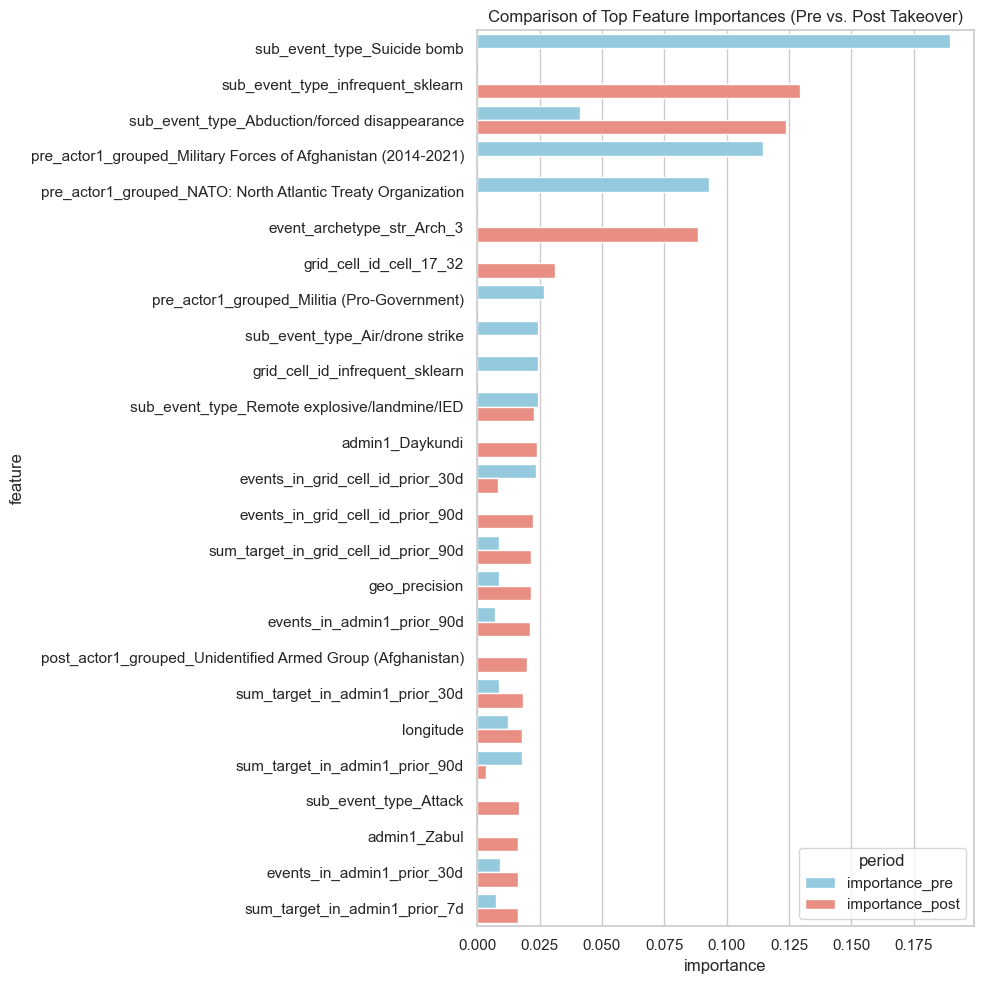


Full ML Pipeline Notebook Finished.


In [74]:
# Cell 11: Compare Model Performance and Feature Importances
print("\n--- Model Comparison (Pre vs. Post Takeover) ---")
if results_pre:
    print(f"\nPre-Takeover Model Test Metrics: RMSE={results_pre['RMSE']:.3f}, MAE={results_pre['MAE']:.3f}, R2={results_pre['R2']:.3f}")
    if importances_pre is not None: print("Top 5 Pre-Takeover Features:"); display(importances_pre.head(5))
if results_post:
    print(f"\nPost-Takeover Model Test Metrics: RMSE={results_post['RMSE']:.3f}, MAE={results_post['MAE']:.3f}, R2={results_post['R2']:.3f}")
    if importances_post is not None: print("Top 5 Post-Takeover Features:"); display(importances_post.head(5))

if importances_pre is not None and importances_post is not None:
    merged_importances = pd.merge(
        importances_pre.rename(columns={'importance':'importance_pre'}),
        importances_post.rename(columns={'importance':'importance_post'}),
        on='feature', how='outer').fillna(0)
    merged_importances['max_importance'] = merged_importances[['importance_pre', 'importance_post']].max(axis=1)
    top_features_merged = merged_importances.sort_values(by='max_importance', ascending=False).head(min(25, len(merged_importances)))
    if not top_features_merged.empty:
        top_features_melted = top_features_merged.melt(id_vars='feature', value_vars=['importance_pre', 'importance_post'], var_name='period', value_name='importance')
        plt.figure(figsize=(10, max(8, len(top_features_merged)*0.4) ))
        sns.barplot(data=top_features_melted, y='feature', x='importance', hue='period', palette={'importance_pre':'skyblue', 'importance_post':'salmon'})
        plt.title('Comparison of Top Feature Importances (Pre vs. Post Takeover)'); plt.tight_layout(); plt.show(); plt.close()
    else: print("No common top features to plot for comparison or merged importances empty.")
else: print("\nCould not generate comparative feature importance plot.")
print("\nFull ML Pipeline Notebook Finished.")